###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, heterogeneous models are from [this Jupyter notebook](https://krischer.github.io/seismo_live_build/html/Computational%20Seismology/The%20Finite-Difference%20Method/fd_ac2d_heterogeneous_wrapper.html) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Florian Wölfl and Lion Krischer ([@krischer](https://github.com/krischer)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/), notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D acoustic finite-difference modelling

One approximation of the elastic equations of motion is the 2D acoustic wave equation. In this notebook we will discuss the finite difference approximation and model wave propagation for problems of different complexity. From a simple homogeneous half-space to complex subsurface models with significant spatial variations of the acoustic (P-wave) velocity. 

## Finite difference solution of 2D acoustic wave equation

As derived in [this](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/3_Acoustic_medium.ipynb) and [this lecture](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/4_2D_1D_elastic_acoustic_approx.ipynb), the acoustic wave equation in 2D with constant density is

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial t^2} \ = \ vp(x,z)^2 \biggl(\frac{\partial^2 p(x,z,t)}{\partial x^2}+\frac{\partial^2 p(x,z,t)}{\partial z^2}\biggr) + f(x,z,t) \nonumber
\end{equation}

with pressure $p$, acoustic velocity $vp$ and source term $f$. We can split the source term into a spatial and temporal part. Spatially, we assume that the source is localized at one point ($x_s, z_s$). Therefore, the spatial source contribution consists of two Dirac $\delta$-functions $\delta(x-x_s)$ and $\delta(z-z_s)$. The temporal source part is an arbitrary source wavelet $s(t)$:

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial t^2} \ = \ vp(x,z)^2 \biggl(\frac{\partial^2 p(x,z,t)}{\partial x^2}+\frac{\partial^2 p(x,z,t)}{\partial z^2}\biggr) + \delta(x-x_s)\delta(z-z_s)s(t) \nonumber
\end{equation}

Both second derivatives can be approximated by a 3-point difference formula. For example for the time derivative, we get:

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial t^2} \ \approx \ \frac{p(x,z,t+dt) - 2 p(x,z,t) + p(x,z,t-dt)}{dt^2}, \nonumber
\end{equation}

and similar for the spatial derivatives: 

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial x^2} \ \approx \ \frac{p(x+dx,z,t) - 2 p(x,z,t) + p(x-dx,z,t)}{dx^2}, \nonumber
\end{equation}

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial x^2} \ \approx \ \frac{p(x,z+dz,t) - 2 p(x,z,t) + p(x,z-dz,t)}{dz^2}, \nonumber
\end{equation}

Injecting these approximations into the wave equation allows us to formulate the pressure p(x) for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an **explicit time integration scheme** allowing the $extrapolation$  of the space-dependent field into the future only looking at the nearest neighbourhood.

In the next step, we discretize the P-wave velocity and pressure wavefield at the discrete spatial grid points 

\begin{align}
x &= i*dx\nonumber\\
z &= j*dz\nonumber\\
\end{align}

with $i = 0, 1, 2, ..., nx$, $j = 0, 1, 2, ..., nz$ on a 2D Cartesian grid.

<img src="images/2D-grid_cart_ac.png" width="75%">

Using the discrete time steps

\begin{align}
t &= n*dt\nonumber
\end{align}

with $n = 0, 1, 2, ..., nt$ and time step $dt$, we can replace the time-dependent part (upper index time, lower indices space) by

\begin{equation}
 \frac{p_{i,j}^{n+1} - 2 p_{i,j}^n + p_{i,j}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{i,j}^2 \biggl( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2}\biggr) \ + \frac{s_{i,j}^n}{dx\;dz}. \nonumber
\end{equation}

The spatial $\delta$-functions $\delta(x-x_s)$ and $\delta(z-z_s)$ in the source term are approximated by the boxcar function:

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

Solving for $p_{i,j}^{n+1}$ leads to the extrapolation scheme:

\begin{equation}
p_{i,j}^{n+1} \ = \ vp_{i,j}^2 \mathrm{d}t^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial z^2} \right) + 2p_{i,j}^n - p_{i,j}^{n-1} + \frac{\mathrm{d}t^2}{dx\; dz} s_{i,j}^n.
\end{equation}

The spatial derivatives are determined by 

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial x^2} \ \approx \ \frac{p_{i+1,j}^{n} - 2 p_{i,j}^n + p_{i-1,j}^{n}}{\mathrm{d}x^2} \nonumber
\end{equation}

and

\begin{equation}
\frac{\partial^2 p(x,z,t)}{\partial z^2} \ \approx \ \frac{p_{i,j+1}^{n} - 2 p_{i,j}^n + p_{i,j-1}^{n}}{\mathrm{d}z^2}. \nonumber
\end{equation}

Eq. (1) is the essential core of the 2D FD modelling code. Because we derived analytical solutions for wave propagation in a homogeneous medium, we should test our first code implementation for a similar medium, by setting

\begin{equation}
vp_{i,j} = vp0\notag
\end{equation}

at each spatial grid point $i = 0, 1, 2, ..., nx$; $j = 0, 1, 2, ..., nz$, in order to compare the numerical with the analytical solution. For a complete description of the problem we also have to define initial and boundary conditions. The **initial condition** is 

\begin{equation}
p_{i,j}^0 = 0, \nonumber
\end{equation}

so the modelling starts with zero pressure amplitude at each spatial grid point $i, j$. As **boundary conditions**, we assume 

\begin{align}
p_{i,0}^n = 0, \nonumber\\
\end{align}

for all time steps n at the top boundary. This **Dirichlet boundary condition**, leads to a boundary reflection which represents a free-surface reflection, which would occur. At the other boundaries, we damp artifical reflections using an **Absorbing Boundary frame** in order to model a realistic half-space model. For further details, how to implement this boundary frame, I refer to [this notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/4_fdac2d_absorbing_boundary.ipynb). 

Let's implement the 2D acoustic FD modelling code. As usual, we first import the required Python libraries ...

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

... define the modelling parameters ...

In [3]:
# Definition of initial modelling parameters
# ------------------------------------------
xmax = 2000.0 # maximum spatial extension of the 1D model in x-direction (m)
zmax = xmax   # maximum spatial extension of the 1D model in z-direction (m)
dx   = 10.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)

tmax = 0.75    # maximum recording time of the seismogram (s)
dt   = 0.0010 # time step

vp0  = 3000.  # P-wave speed in medium (m/s)

# acquisition geometry
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

f0   = 100.0 # dominant frequency of the source (Hz)
t0   = 0.1   # source time shift (s)

isnap = 1  # snapshot interval (timesteps)

... compute the spatial derivatives in a function `update_d2px_d2pz` ...

In [4]:
@jit(nopython=True) # use JIT for C-performance
def update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
                
            d2px[i,j] = (p[i + 1,j] - 2 * p[i,j] + p[i - 1,j]) / dx**2                
            d2pz[i,j] = (p[i,j + 1] - 2 * p[i,j] + p[i,j - 1]) / dz**2
        
    return d2px, d2pz   

... define the absorbing boundary frame at the left, right and bottom boundary in the function `absorb`

In [5]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

Finally, we assemble all parts in the 2D acoustic finite difference modelling code `FD_2D_acoustic_JIT`

In [6]:
# FD_2D_acoustic code with JIT optimization
# -----------------------------------------
def FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc):        
    
    # define model discretization
    # ---------------------------

    nx = (int)(xmax/dx) # number of grid points in x-direction
    print('nx = ',nx)

    nz = (int)(zmax/dz) # number of grid points in x-direction
    print('nz = ',nz)

    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)

    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2)) 
    
    # define clip value: 0.1 * absolute maximum value of source wavelet
    clip = 0.1 * max([np.abs(src.min()), np.abs(src.max())]) / (dx*dz) * dt**2
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Define model
    # ------------    
    vp  = np.zeros((nx,nz))
    vp  = model(nx,nz,vp,dx,dz)    
    vp2 = vp**2
    
    # Initialize empty pressure arrays
    # --------------------------------
    p    = np.zeros((nx,nz)) # p at time n (now)
    pold = np.zeros((nx,nz)) # p at time n-1 (past)
    pnew = np.zeros((nx,nz)) # p at time n+1 (present)
    d2px = np.zeros((nx,nz)) # 2nd spatial x-derivative of p
    d2pz = np.zeros((nx,nz)) # 2nd spatial z-derivative of p    
    
    # Initalize animation of pressure wavefield 
    # -----------------------------------------    
    fig = plt.figure(figsize=(8,2.5))  # define figure size
    plt.tight_layout()
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot pressure wavefield movie
    ax1 = plt.subplot(121)
    image = plt.imshow(p.T, animated=True, cmap="RdBu", extent=extent, 
                          interpolation='spline36', vmin=-clip, vmax=clip)        
    plt.title('Pressure wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    cbar = plt.colorbar(image)
    cbar.set_label(r'Pressure [Pa]')
    
    # Plot Vp-model
    ax2 = plt.subplot(122)
    image1 = plt.imshow((vp.T)/1000, cmap=plt.cm.viridis, interpolation='nearest', 
                        extent=extent)
    
    cbar1 = plt.colorbar(image1)
    cbar1.set_label(r'$V_p$ [km/s]')
    plt.title('Vp-model')
    plt.xlabel('x [m]')
    plt.setp(ax2.get_yticklabels(), visible=False)
    
    plt.ion()    
    plt.show(block=False)
    
    snap_count = 0
    
    # Calculate Partial Derivatives
    # -----------------------------
    for it in range(nt):
    
        # FD approximation of spatial derivative by 3 point operator
        d2px, d2pz = update_d2px_d2pz(p, dx, dz, nx, nz, d2px, d2pz)

        # Time Extrapolation
        # ------------------
        pnew = 2 * p - pold + vp2 * dt**2 * (d2px + d2pz)

        # Add Source Term at isrc
        # -----------------------
        # Absolute pressure w.r.t analytical solution
        pnew[isrc,jsrc] = pnew[isrc,jsrc] + src[it] / (dx * dz) * dt ** 2
        
        # Apply absorbing boundary frame
        # ------------------------------
        p *= absorb_coeff
        pnew *= absorb_coeff
        
        # Remap Time Levels
        # -----------------
        pold, p = p, pnew
    
        # display pressure snapshots 
        if (it % isnap) == 0:
            image.set_data(p.T)
            fig.canvas.draw()  
            
            # write snapshots to Tiff files
            name_snap = "image_out/acoustic_2D_" + "%0.*f" %(0,np.fix(snap_count+1000)) + ".tiff"
            plt.savefig(name_snap, format='tiff', bbox_inches='tight', dpi=125)
            snap_count += 1
            
    return vp        

## Problem 1: Homogeneous Model

Let 's start with a very simple problem - a homogeneous half-space model. We can define, and later modify, the subsurface model in the function `model`:

In [7]:
# Homogeneous model
def model(nx,nz,vp,dx,dz):
    
    vp += vp0 
    
    return vp

Time to define some additional modelling parameters:

- We place an explosive source, e.g. representing a subsurface nuclear explosion test, in the center of the model at $(xsrc,zsrc)^T$ = $(1000\; m,1000\; m)^T$

- Use a spatial sampling interval $dx = dz = 5\; m$ of the finite-difference grid

- Define the centre frequency of the source wavelet

- Calculate the time sample interval $dt$ in order to satisfy the CFL-criterion.

before finally running the FD code ...

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


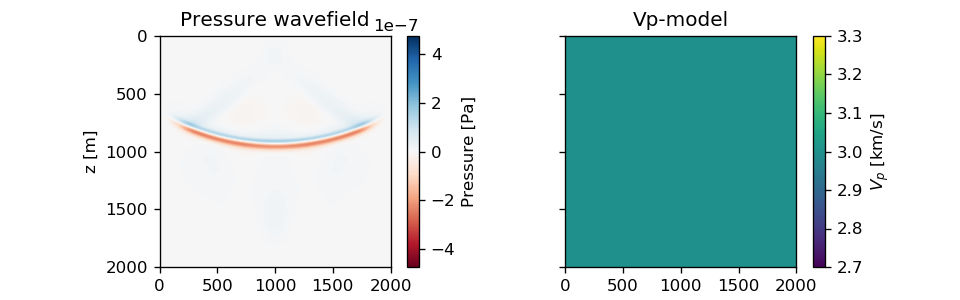

In [8]:
%matplotlib notebook
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc   # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vp0)

vp_hom = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

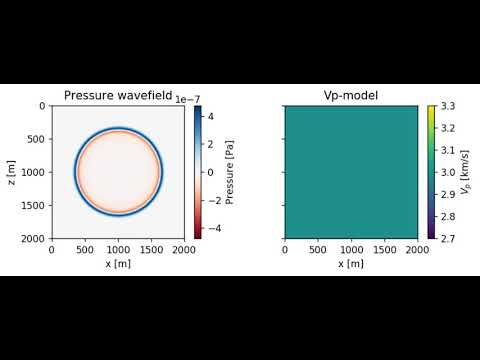

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('97QY9vDaEbo')

Notice, how the P-wavefront propagates in all directions, is absorbed at the left, right and bottom boundary, while reflected at the free-surface boundary on top, representing the earth surface.

## Problem 2: Random Medium

Next, we add some random perturbations to the homogeneous Vp-model:

In [9]:
# Random medium model
def model(nx,nz,vp,dx,dz):
        
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    vp += vp0 * (1 + r)
    
    return vp

nx =  400
nz =  400
nt =  890


<IPython.core.display.Javascript object>


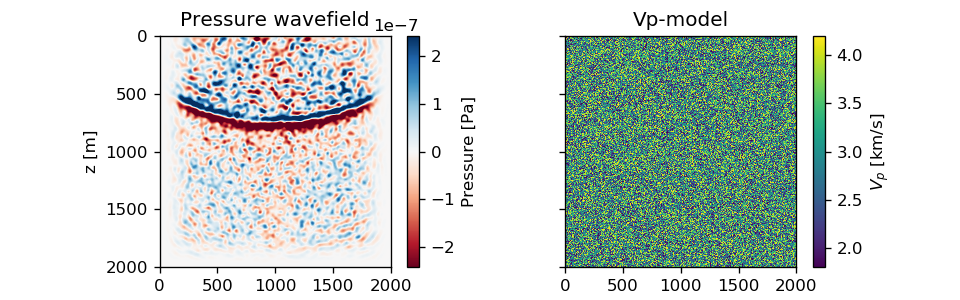

In [10]:
xsrc = 1000.0 # x-source position (m)
zsrc = xsrc    # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = 4200.0
# vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_rand = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

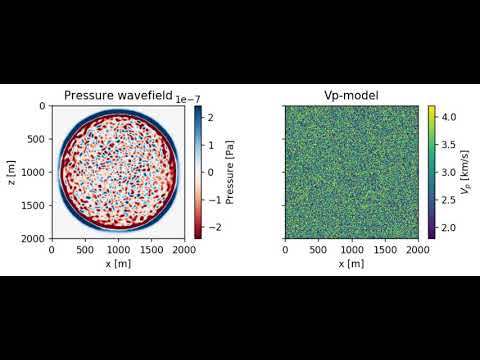

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('Kvbrw5oXSfY')

As in the first example, we get a circular P-wavefront. However, the small scale random model variations scatter the seismic energy, leading to a significant damping of the direct P-wave amplitude.

## Problem 3: Fault Zone

In this problem, we model acoustic wave propagation in a vertical fault zone

In [11]:
# Vertical fault zone model
def model(nx,nz,vp,dx,dz):
    
    fault_ext = 25.0           # half-extension of the fault in x-direction (m)
    n_ft = (int)(fault_ext/dx) # half-extension of the fault in x-direction (gridpoints)
    vp += vp0
    vp[nx // 2 - n_ft: nx // 2 + n_ft,:] *= 0.8     
        
    return vp

nx =  400
nz =  400
nt =  890


<IPython.core.display.Javascript object>


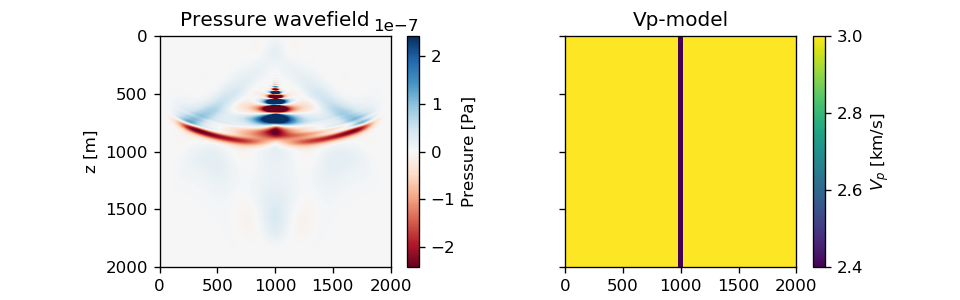

In [12]:
xsrc = 1000.0 # x-source position (m)
zsrc = 1000.0 # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.0  # centre frequency of the source wavelet (Hz)
vpmax = 4200.0
# vpmax = np.max(vp0)

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_fault = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

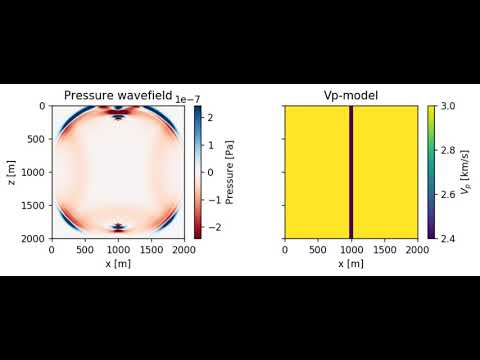

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('1anNRXd1cpU')

The vertical low-velocity fault leads to the development of an acoustic interface wave, sticking to the fault zone, with a lower velocity compared to the body P-wave propagating in the homogeneous medium, surrounding the fault zone.

## Problem 4: Simplified Vulcano

How does the surface topography of a vulcano scatter the acoustic wavefield?

In [13]:
# Simplified vulcano (Gaussian hill)
def model(nx,nz,vp,dx,dz):
    
    vp += vp0 # fill model with vp0
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            depth = j * dz  # depth of grid point j (m)
            x = i * dx      # horizontal distance of grid point i (m)
            
            x_center = (int)(nx/2) * dx  # center of vulcano cone            
            height_vul = 1500.0          # vulcano height
            sigma = 500.0                # half-width of vulcano cone
            
            # approximate vulcano topography by Gaussian hill
            topo = - height_vul * np.exp(-(x - x_center)**2/sigma**2) + dx*nz
            
            # add air above the topography
            if(depth < topo):
                vp[i,j] = 0.0
            
    return vp

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


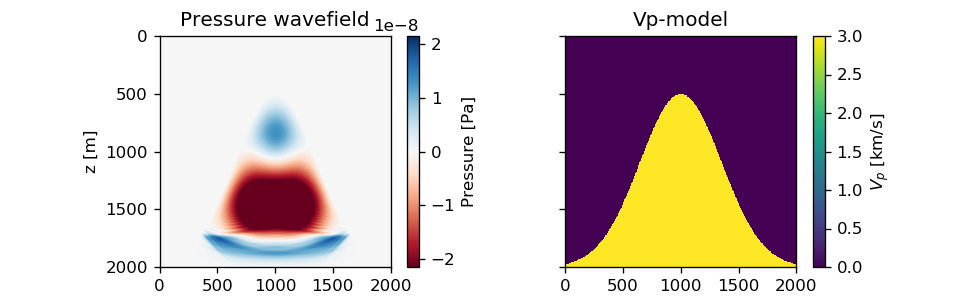

In [14]:
xsrc = 1000.0 # x-source position (m)
zsrc = 1250.0 # z-source position (m)

dx   = 5.0   # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 4.5  # centre frequency of the source wavelet (Hz)
vpmax = vp0

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_topo = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

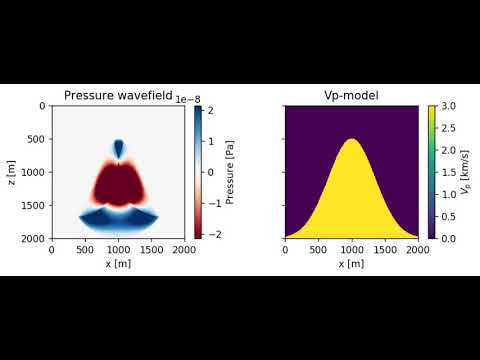

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('52YBfHOvAUI')

Modelling example 3, represents the occurence of a microseismic event in a Gaussian shaped volcano. Such events can be related to the movement of magma in the volcanic cone. After a short time, the seismic event leads to natural oscillations of the volcano.

## Problem 4: Building velocity models based on images

It is a quite tedious approach to build complex velocity models via IF-statements in the FOR-loops over the Cartesian FD grid. Alternatively, you can read an image and match colors with seismic P-wave velocities. Be sure to use PNGs or other non-compression image formats in order to avoid problems with compression artifacts. Let's take a look at this subsurface model, based on the image file `subsurface.png` located in the `images` directory:

In [17]:
# Build "realistic" subsurface model based on imported image

from scipy import misc # import image read from scipy

def model(nx,nz,vp,dx,dz):
    
    # read jpeg image - be sure that the number of pixels coincides 
    # with the number of grid points nx and ny of the FD model
    image = misc.imread('images/subsurface.png')
    image_red = image[:,:,0]  # extract red channel
    
    vp += vp0 # fill model with vp0
    
    for i in range(0,nx):
        for j in range(0,nz):
            
            # assume vaccum in the violet caves
            vp[i,j] = 0.
            
            # if image_red[j,i]<50, set vp = 2000 m/s
            if(image_red[j,i]<112):
                vp[i,j] = 2000.
                
            # if image_red[j,i]>200, set vp = 3000 m/s
            if(image_red[j,i]>150):
                vp[i,j] = 2700.
                
    return vp

nx =  400
nz =  400
nt =  636


<IPython.core.display.Javascript object>


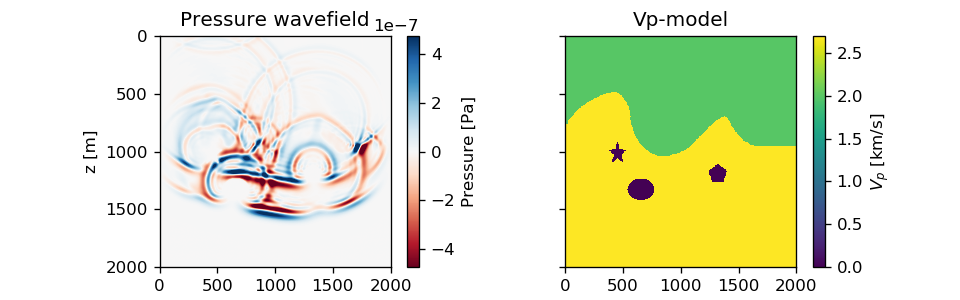

In [18]:
xsrc = 1000.0 # x-source position (m)
zsrc = 100.0  # z-source position (m)

dx   = 5.0    # grid point distance in x-direction (m)
dz   = dx     # grid point distance in z-direction (m)
f0   = 100.   # centre frequency of the source wavelet (Hz)
vpmax = vp0

# calculate dt according to the CFL-criterion
dt = dx / (np.sqrt(2.0) * vpmax)

vp_image = FD_2D_acoustic_JIT(dt,dx,dz,f0,xsrc,zsrc)

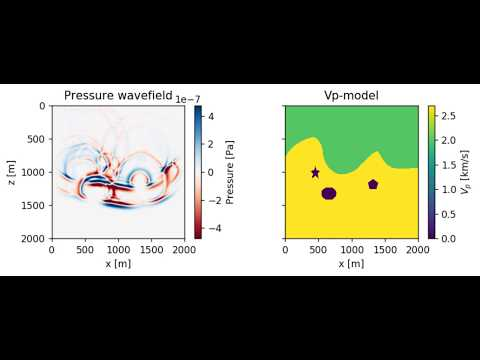

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('cQoshYobv_0')

In this complex subsurface model, the interface between the top low-velocity layer with $vp=2000\;m/s$ and the underlying model with $vp=2700\;m/s$, as well as the cavities leads to a complex seismic wavefield, consisting of reflections and diffractions.

## Problem 6: Create your own problem here

##### Excercise

Now it's your turn, create a 2D P-wave velocity model and compute the pressure
wavefield by 2D acoustic FD modelling. Pay attention to satisfy the CFL and grid dispersion criteria by choosing appropriate spatial grid point distances $dx = dz$
and time step dt.

## What we learned:

- How to model P-wave propgation in simple heterogeneous 2D acoustic media 